In [1]:
from Bio import Entrez

In [2]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys; sys.path.append(".")

Let's let the nice folks at NCBI know who we are.

In [3]:
Entrez.email = "jb9255@fri.uni-lj.si"

# How is SARS-CoV-2 spreading?

In the previous homework, we saw that we can infer how closely related different viruses are to one another by constructing pyhlogenetic trees. We know from biology and the theory of evolution that, if the organism are related to one another, they probably shared a common ancestor at some point in the past. The branching structure of the dendrograms hints at the possible time-frame of evolutionary distances between viruses.

Why not apply this same logic to a single, rapidly-mutating virus? SARS-CoV-2 is a RNA virus and mutates at a much faster rate than DNA-based organisms since it lacks many of the proof-reading and correction machinery that DNA-based organisms have. Could we trace the evolutionary path of this pesky virus from the time it was first reported to now by looking at different instances of SARS-CoV-2? Has it mutated in any major way? Is mutation related to geography? After all, we spread infect people close to us, so will we find that the virus went in a different evolutionary direction in different countries, continents? Let this be our motivation for the upcoming assignments.

![](https://images.theconversation.com/files/329931/original/file-20200423-47832-10m83yi.jpg?ixlib=rb-1.1.0&rect=17%2C8%2C726%2C370&q=45&auto=format&w=1000&fit=clip)

## Problem 1: UPGMA

In the previous homework we used hierarchical clustering algorithms implemented in scipy. This time, we will implement one of these clustering algorithms ourselves.

**TASK:** Implement the UPGMA algorithm you learned about in lectures for agglomerative hierarchical clustering in the `UPGMA` function in `helper_functions.py`. Your implementation should return a linkage matrix following the same format as that of `scipy.cluster.hierarchy.linkage`, so we can easily plot the dendrogram using existing scipy utilities. See the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) for the exact format. **[10 points]**

Hint: UPGMA is the same as hierarchical clustering using average linkage.

Once you have implemented the UPGMA algorithm, proceed to Problem 2.

In [4]:
from helper_functions import UPGMA

## Problem 2: Phylogenetic analysis

You are given 108 aligned sequences of SARS-CoV-2 collected at different time points around the world. Using the UPGMA algorithm you implemented earlier, plot a dendrogram of the sequences.

The aligned sequences are provided in *data/sars-cov-2.fa* in the fasta format. You can easily read these files using biopython's `SeqIO.parse`. Each record consists of a header indicating the accession id and the aligned sequence. You will need to use the standard NCBI fetching utilities we used in the previous homework to get metadata for each of the provided sequences.

Each NCBI record contains lots of interesting metadata. For the purposes of this homework, we really need three pieces of information. We need to know when the sequence was collected i.e. the collection date, which host the sequence was collected from e.g. humans, mice, ... (in case the host is not given, we can assume a human host), and where/what country the sequence was collected in. We can also convince ourselves that all the viruses are, in fact, SARS-CoV-2 viruses. All of this information can be found in an NCBI sequence record. Scan through the `record.features` field and search for one with `feature.type == "source"`. This object contains several qualifiers which contain all the required metadata.

**TASK:** We first need to calculate pairwise distances between each of our sequences. We'll do this in the same way as in Homework 2, using Hamming distance i.e. the number of mismatching symbols. This is sometimes also refered to as _genetic distance_. Implement the Jukes-Cantor correction in `helper_functions.py`. Apply the correction to the distances (see below for more information on Jukes-Cantor, you will learn more about this in future lectures). Since the sequences are already aligned, you do not have to perform the time-intensive alignment proceedure. Construct the dendrogram using your UPGMA implementation. Plot the phylogenetic tree using existing scipy utilities and save the resulting dendrogram into `problem2.png`. Label the tree branches using the accession id, the country or continent where the sequence was collected, and the collection date. Do the results make sense? Do you see any geographic grouping? What about grouping based on collection date. Save your answers into the `dendrogram_comments` variable.
**[10 points]** 

Hint: check out `scipy.cluster.hierarchy.dendrogram` to plot the dendrogram. Use `pandas.to_datetime` to parse and work with dates more easily.

**Jukes-Cantor correction**:
Estimating the genetic distance between two sequences is not as straightforward as it may initially seem. For instance, consider two nucleotides AC. Lets imagine this sequence undergoes the following mutations: AC -> CC -> TC -> GC -> TC. And imagine we observed onlt the first sequence i.e. AC and the last sequence TC. What is the distance between these two sequences? Well, AC and TC only differ in the first nucleotide, so their genetic distance must be 1. But, we know from the above transitions that there have actually been four mutations. So our naive estimation of genetic distance systematically underestimates the distance between sequences. One way to correct for this is by using the Jukes-Cantor correction. You can read more about it in the book "Introduction to Computational Genomics" by Cristianini and Hahn in section 5.4.1. But in essence, your job is to correct the distances in the following way. 1 - calculate the Hamming/genetic distance between sequences. 2 - convert these distances to proportions of the sequence length i.e. divide the distances by the lengths of the sequences being compared (in the above example, we would have 1 mutation and sequence length 2, therefore the proportianal distance would be 0.5). 3 - Calculate the correction using d_corrected = -3/4 log (1 - 4/3 d_proportions).

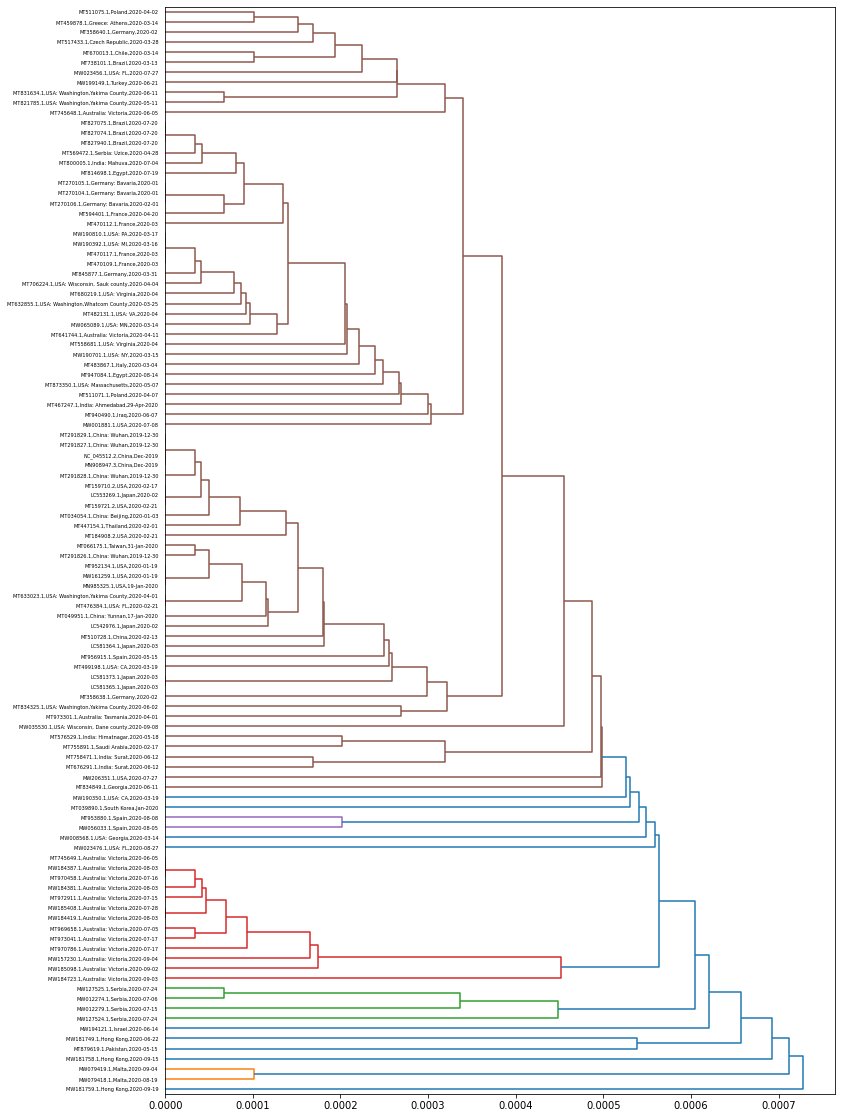

In [5]:
from Bio import SeqIO
import numpy as np
from helper_functions import jukes_cantor
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import os
import math

"""Read sequences"""
fasta_sequences = SeqIO.parse(open("data/sars-cov-2.fa"),'fasta')
qualifiers = []
labelz = []
sequences = []
"""Get sequence metadata - that is collection_date, host(default is homo sapiens) and country identifiers"""
for fasta_sequence in fasta_sequences:
    with Entrez.efetch(db="nucleotide", rettype="gb", id=fasta_sequence.id) as handle:
        record = SeqIO.read(handle, "gb")
        sequences.append(fasta_sequence.seq)
        for feature in record.features:
            if feature.type == "source":
                qualifiers.append(feature.qualifiers)
                labelz.append(str(fasta_sequence.id)+","+str(feature.qualifiers["country"][0])+","+str(feature.qualifiers["collection_date"][0]))
"Setup distances matrix. Check if distances matrix is already cached, otherwise calculate them and store the matrix"
num_of_sequences = len(sequences)
distances_mat = np.zeros((num_of_sequences, num_of_sequences))
if os.path.exists( "distances_mat.dat"):
    distances_mat = np.load("distances_mat.dat",allow_pickle=True)
else:
    """Calculate distances between pairs of sequences"""
    for i in range(num_of_sequences):
        for j in range(i):
            distance = 0
            seq_len = len(sequences[i])
            for k in range(seq_len):
                if sequences[i][k] != sequences[j][k]:
                    distance = distance + 1
            distances_mat[i][j] = jukes_cantor(distance/seq_len)
            distances_mat[j][i] = distances_mat[i][j]
    """ Store the matrix """        
    distances_mat.dump("distances_mat.dat") 
"""Calculate UPGMA, draw dendrogram and save it to problem2.png"""
z = UPGMA(distances_mat)
fig = plt.figure(figsize=(12,20))
dendrogram(z, orientation='right',
            labels=[x for x in labelz],
            distance_sort='descending')
plt.savefig("problem2.png")

dendrogram_comments = """
It can be seen that the way some samples are clusters coresponds to the country they were collected (Australia, Serbia, Malta,...).
The same cannot be said about the date they were collected at, as it doesn't look to be correlated that way.
"""

## Problem 3a: Rate of mutation

**TASK:** Find the virus with the earliest collection date -- we'll use this as our starting point for any subsequent mutations. Calculate the genetic distance (with the JC correction) from this starting sequence to all the other sequences and plot the dependence of genetic distance to the time elapsed from this starting point. Put genetic distance on the y-axis, and time in days (the number of days since the starting point) on your x-axis. The starting point should be located at the origin. Fit a linear regression line to the points and overlay the regression line onto your plot. Save the resulting figure into `problem3a.png`. Report the slope of the line and save it into the `sars_cov_2_coeff` variable. Write down any comments into the `sars_cov_2_mutation_comments` variable.
**[5 points]** 

Hint: check out `np.polyfit` to fit the linear regression curve.

Sars_cov_2_coeff: 1.8105030746624846e-06


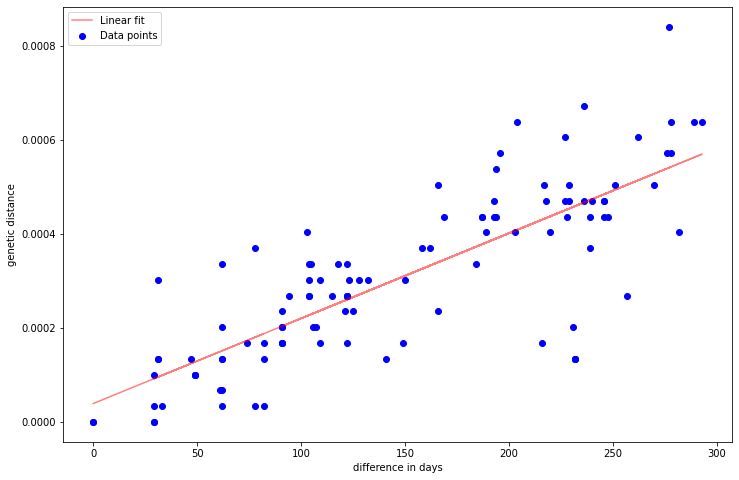

In [6]:
import pandas as pd
indx = -1
i = 0
earliest_date = pd.to_datetime('today').date()
dates = []
""" Get dates """
for q in qualifiers:
    cur_date = pd.to_datetime(q["collection_date"][0]).date()
    dates.append(cur_date)
    if cur_date < earliest_date:
        earliest_date = cur_date
        indx = i
    i += 1
x_days_diffs = [0]
y_distances = [0]
seq_len = len(sequences[indx])
""" Calculate distances and difference in days"""
for i in range(num_of_sequences):
    if i != indx:
        distance = 0
        for k in range(seq_len):
            if sequences[i][k] != sequences[indx][k]:
                distance = distance + 1
        days_diff = dates[i] - dates[indx]
        x_days_diffs.append(days_diff.days)
        y_distances.append(jukes_cantor(distance/seq_len))
plt.figure(figsize=(12,8))        
plt.xlabel('difference in days')
plt.ylabel('genetic distance')
fit = np.polyfit(x_days_diffs,y_distances,1)
coeff = fit[0]
intercept = fit[1]
fit_eq = coeff*np.asarray(x_days_diffs) + intercept
plt.plot(x_days_diffs,fit_eq,color="r",alpha = 0.5, label = 'Linear fit')
plt.scatter(x_days_diffs,y_distances, color = 'b', label = 'Data points')
plt.legend()
plt.savefig("problem3a.png")
print("Sars_cov_2_coeff: "+str(coeff))
sars_cov_2_coeff = 1.8105030746624846e-06
sars_cov_2_mutation_comments = """
We can see that over time the virus has been gaining distance to the earliest traits and mutated.
The mutations are not the fastests but are there and virus keeps on evolving over time.
"""

## Problem 3b: Mutation rate in other viruses

How fast is this rate of mutation in SARS-CoV-2? Is it mutating quickly? Or slowly? Or at an average rate? We really can't tell without a frame of reference. In this exercise, we will look at two more viruses, Ebola and HIV, and determine their rate of mutation. These will help us get some kind of reference for the speed at which viruses mutate.

**TASK:** Find the aligned sequences for Ebola and HIV viruses in the accompanying fasta files. You will again need to download the sequence metadata from NCBI. As in 3a, estimate the slope of the regression line for each of the viruses. Report the slopes of both lines and save them to their corresponding variables, `ebola_coeff` and `hiv_coeff`. Given this reference frame, how fast is SARS-CoV-2 mutating? Examine the ratios of the slopes. Write your observations into the `mutation_comments` variable.
**[5 points]** 

**A note on HIV.** HIV has been around for a long time, and when it first appeared, high-throughput sequencing technologies were still in their infancy. Therefore sequences are much harder to come by. You will notice that whichever staring point you choose, the sequences are all further from each other than in Ebola and SARS-CoV-2. On your plots, this will become apparent as the starting point will be located at the origin, and the remaining sequences will all be shifted higher up the y-axis. However, the rate of mutation is fairly constant, so you can still estimate the rate of mutation by looking at the regression line. This is because the viruses will be much more different from one another. However, we can still look at the differences over time to estimate the rate of mutation. Just be sure to exclude the starting point (origin) from the linear regression fit, as this will skew the regression line.

ebola_coeff: 2.2914319448737395e-06


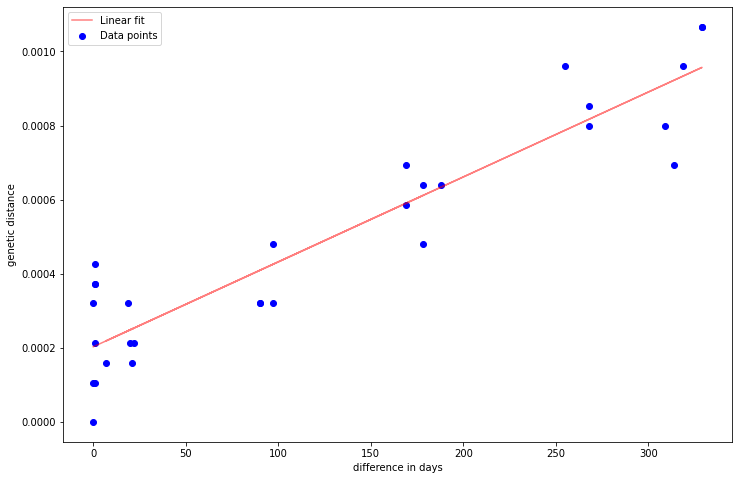

In [7]:
fasta_sequences = SeqIO.parse(open("data/ebola.fa"),'fasta')
ebola_qualifiers = []
ebola_sequences = []
for fasta_sequence in fasta_sequences:
    with Entrez.efetch(db="nucleotide", rettype="gb", id=fasta_sequence.id) as handle:
        record = SeqIO.read(handle, "gb")
        ebola_sequences.append(fasta_sequence.seq)
        for feature in record.features:
            if feature.type == "source":
                ebola_qualifiers.append(feature.qualifiers)
num_of_sequences_ebola = len(ebola_sequences)
ebola_indx = -1
i = 0
ebola_earliest_date = pd.to_datetime('today').date()
ebola_dates = []
""" Get dates """
for q in ebola_qualifiers:
    cur_date = pd.to_datetime(q["collection_date"][0]).date()
    ebola_dates.append(cur_date)
    if cur_date < ebola_earliest_date:
        ebola_earliest_date = cur_date
        ebola_indx = i
    i += 1
ebola_x_days_diffs = [0]
ebola_y_distances = [0]
ebola_seq_len = len(ebola_sequences[ebola_indx])
""" Calculate distances and difference in days"""
for i in range(num_of_sequences_ebola):
    if i != ebola_indx:
        distance = 0
        for k in range(ebola_seq_len):
            if ebola_sequences[i][k] != ebola_sequences[ebola_indx][k]:
                distance = distance + 1
        ebola_days_diff = ebola_dates[i] - ebola_dates[ebola_indx]
        ebola_x_days_diffs.append(ebola_days_diff.days)
        ebola_y_distances.append(jukes_cantor(distance/ebola_seq_len))
plt.figure(figsize=(12,8))  
plt.xlabel('difference in days')
plt.ylabel('genetic distance')
ebola_fit = np.polyfit(ebola_x_days_diffs,ebola_y_distances,1)
ebola_coeff = ebola_fit[0]
ebola_intercept = ebola_fit[1]
ebola_fit_eq = ebola_coeff*np.asarray(ebola_x_days_diffs) + ebola_intercept
plt.plot(ebola_x_days_diffs,ebola_fit_eq,color="r",alpha = 0.5, label = 'Linear fit')
plt.scatter(ebola_x_days_diffs,ebola_y_distances, color = 'b', label = 'Data points')
plt.legend()
plt.savefig("problem3b_ebola.png")
print("ebola_coeff: "+str(ebola_coeff))


hiv_coeff: 1.8648381681723006e-05


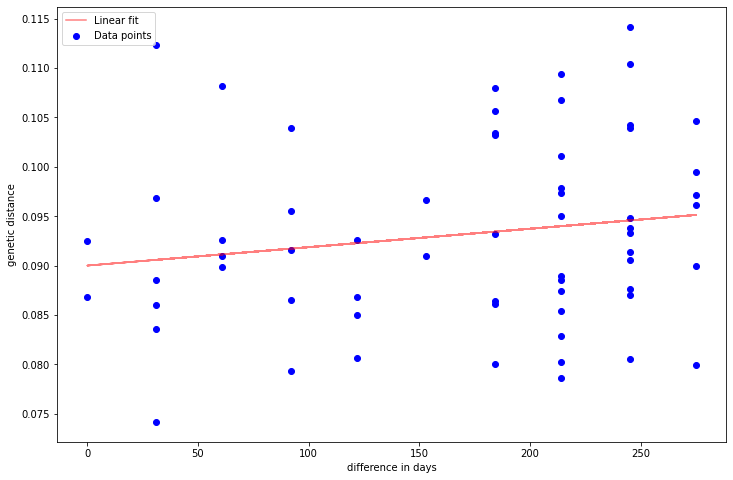

In [8]:
fasta_sequences = SeqIO.parse(open("data/hiv.fa"),'fasta')
hiv_qualifiers = []
hiv_sequences = []
for fasta_sequence in fasta_sequences:
    with Entrez.efetch(db="nucleotide", rettype="gb", id=fasta_sequence.id) as handle:
        record = SeqIO.read(handle, "gb")
        hiv_sequences.append(fasta_sequence.seq)
        for feature in record.features:
            if feature.type == "source":
                hiv_qualifiers.append(feature.qualifiers)
hiv_num_of_sequences = len(hiv_sequences)
hiv_indx = -1
i = 0
hiv_earliest_date = pd.to_datetime('today').date()
hiv_dates = []
""" Get dates """
for q in hiv_qualifiers:
    cur_date = pd.to_datetime(q["collection_date"][0]).date()
    hiv_dates.append(cur_date)
    if cur_date < hiv_earliest_date:
        hiv_earliest_date = cur_date
        hiv_indx = i
    i += 1
hiv_x_days_diffs = []
hiv_y_distances = []
hiv_seq_len = len(hiv_sequences[hiv_indx])
""" Calculate distances and difference in days"""
for i in range(hiv_num_of_sequences):
    if i != hiv_indx:
        distance = 0
        for k in range(hiv_seq_len):
            if hiv_sequences[i][k] != hiv_sequences[hiv_indx][k]:
                distance = distance + 1
        hiv_days_diff = hiv_dates[i] - hiv_dates[hiv_indx]
        hiv_x_days_diffs.append(hiv_days_diff.days)
        hiv_y_distances.append(jukes_cantor(distance/hiv_seq_len))
plt.figure(figsize=(12,8))  
plt.xlabel('difference in days')
plt.ylabel('genetic distance')
hiv_fit = np.polyfit(hiv_x_days_diffs,hiv_y_distances,1)
hiv_coeff = hiv_fit[0]
hiv_intercept = hiv_fit[1]
hiv_fit_eq = hiv_coeff*np.asarray(hiv_x_days_diffs) + hiv_intercept
plt.plot(hiv_x_days_diffs,hiv_fit_eq,color="r",alpha = 0.5, label = 'Linear fit')
plt.scatter(hiv_x_days_diffs,hiv_y_distances, color = 'b', label = 'Data points')
plt.legend()
plt.savefig("problem3b_hiv.png")
print("hiv_coeff: "+str(hiv_coeff))

In [9]:

ebola_coeff = 2.2914319448737395e-06
hiv_coeff = 1.8648381681723006e-05
mutation_comments = """
Based on graphs slope coefficients sars-cov-2 is mutating slower then both ebola and hiv.
There is also difference in the number of samples, which is very low for ebola and can make results less reliable.
Hiv is also way further apart(based on genetic distance between individual samples), while ebola and sars-cov-2 are much closer.
"""

## Problem 4: Zoonotic transmission

There has recently been some talk of SARS-CoV-2 jumping to different animals, namely minks in the Netherlands. Let's see if this is true, and how the virus changed during the jump. These sequences are aligned to the SARS-CoV-2 sequences you worked with in the previous exercises. 

![](https://i.pinimg.com/originals/ac/d9/81/acd981a162499b120ebcaad5b5258981.jpg)

**TASK:** You are given eight SARS-CoV-2 sequences obtained from different animals in the accompanying _sars-cov-2-animals.fa_ fasta file. First, determine which animal species each sequence belongs to, and find out when they were sequenced (look at the collection date). You can find this in the NCBI metadata. Then, add these points to the plot you generated in Exercise 3a i.e. add the points to the plot and highlight them using a different color. Save the resulting figure into `problem4.png`. How do these viral sequences fit into the plot? Did the viruses have to drastically change to infect the animals or are the mutations expected? Write your observations into the `animal_comments` variable.
**[10 points]** 

Animals:
Mustela lutreola
Mustela lutreola
Mustela lutreola
Mustela lutreola
Mustela lutreola
Felis catus
Felis catus
Felis catus


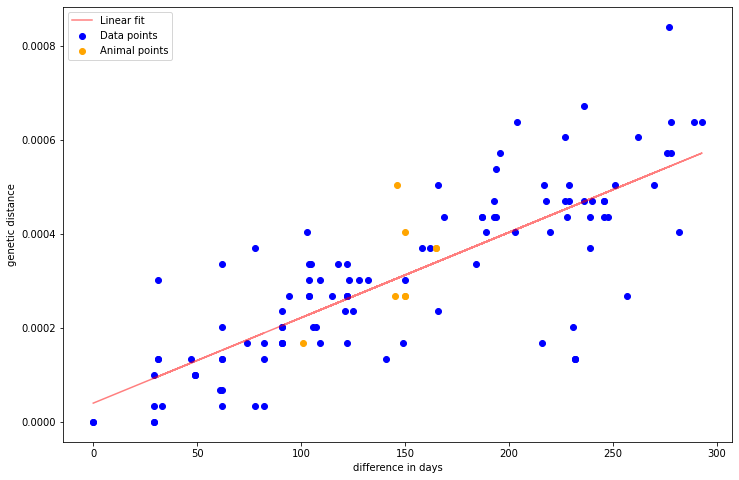

In [10]:
fasta_sequences = SeqIO.parse(open("data/sars-cov-2-animals.fa"),'fasta')
animal_qualifiers = []
animal_sequences = []
print("Animals:")
for fasta_sequence in fasta_sequences:
    with Entrez.efetch(db="nucleotide", rettype="gb", id=fasta_sequence.id) as handle:
        record = SeqIO.read(handle, "gb")
        animal_sequences.append(fasta_sequence.seq)
        for feature in record.features:
            if feature.type == "source":
                print(feature.qualifiers["host"][0])
                animal_qualifiers.append(feature.qualifiers)
animal_num_of_sequences = len(animal_sequences)

i = 0
earliest_date = pd.to_datetime('today').date()
animal_dates = []
a_seq_len = len(sequences[indx])
""" Get dates """
for q in animal_qualifiers:
    cur_date = pd.to_datetime(q["collection_date"][0]).date()
    animal_dates.append(cur_date)
animal_x_days_diffs = []
animal_y_distances = []
""" Calculate distances and difference in days"""
for i in range(animal_num_of_sequences):
        distance = 0
        for k in range(a_seq_len):
            if animal_sequences[i][k] != sequences[indx][k]:
                distance = distance + 1
        days_diff = animal_dates[i] - dates[indx]
        animal_x_days_diffs.append(days_diff.days)
        animal_y_distances.append(jukes_cantor(distance/a_seq_len))
plt.figure(figsize=(12,8))  
plt.xlabel('difference in days')
plt.ylabel('genetic distance')
fit = np.polyfit(x_days_diffs + animal_x_days_diffs,y_distances + animal_y_distances,1)
coeff = fit[0]
intercept = fit[1]
fit_eq = coeff*np.asarray(x_days_diffs) + intercept
plt.plot(x_days_diffs,fit_eq,color="r",alpha = 0.5, label = 'Linear fit')
plt.scatter(x_days_diffs,y_distances, color = 'b', label = 'Data points')
plt.scatter(animal_x_days_diffs,animal_y_distances, color = 'orange', label = 'Animal points')
plt.legend()
plt.savefig("problem4.png")

In [11]:
animal_comments = """
I don't see anything special about those animal samples, except that some are apparently overlapped as only 6 are visible.
Otherwise they fit in the plot nicely. 5 of those samples are of European mink, and 3 are of a cat.
"""

## Bonus problem: Single Nucleotide Polymorphisms

Are all mutations equally possible? Probably not. After all, if we get an unfortunate mutation on our spike protein that flips a key amino-acid, it might well happen that our virus won't be able to bind and enter host cells anymore. Such a mutation would clearly be devastating for the virus and natural selection would quickly eliminate all viruses with this mutation. However, other mutations are probably less devastating and entirely possible. There are only 21 amino acids, and several codons can code for the same amino acid, so a change in nucleotide sequence might not even affect the protein sequence. Therefore, we might expect these mutations to be more common than potentially destructive mutations. And, as you saw in lectures, some proteins belong to the same general family e.g. hydrophylic/hydrophobic, charged, ... and a switch in amino acid with another with the same general properties might not be that bad. Let's take a look.

**TASK:**

For every single nucleotide location on the SARS-CoV-2 aligned sequences, find the distribution of nucleotides across all sequences and calculate its [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)). Plot a bar chart where the nucleotide location is on the x-axis, and the entropy on the y-axis. Since you will be plotting almost 30k bars, increase their width so they actually show up. Save the resulting figure into `problem-snp.png`.

Next, using your ORF finder form HW1, find the longest ORF on each aligned sequence -- this should correspond to ORF1ab at the beginning of the sequence with length 13,218 -- and determine which proteins were changed due to mutations. When translating your ORFs to protein sequences, skip over indels e.g. AT-GC should be treated as ATGC. In case proteins were changed due to mutation look at the table of amino-acids and their properties. Which mutations are most common, and do they make sense? If an amino-acid is changed, does it belong to the same group as the others? You can use the refernece SARS-CoV-2 genome as the reference (NC_045512). Write your observations into the `snp_comments` variable. List at least two interesting mutations, either at the nucleotide level or at the amino-acid level. How many times does the mutation occur? Why are they interesting?

**[10 points]**

Your ORF finder only needs to be able to find ORFs on the + strand, so even if you haven't implement your ORF finder entirely correctly, it should not be an issue. In case your ORF finder does not find ORFs on the + strand correctly, please reach out and we'll get it sorted.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/Amino_Acids.svg/700px-Amino_Acids.svg.png)

In [14]:
snp_comments = """
List at least two interesting mutations. How many times do they occur? Why are they interesting?
"""

## Bonus problem: Pretty dendrograms

Flame wars are fought every day online as people argue between which programming language is better. These battles are never won or lost, as each side stubbornly sticks to their guns, not budging a single inch from their respective standpoints. Every few years, new contenders enter the fray and the world is ever more divided. In bioinformatics, it usually comes down to Python versus R (despite what Julia fans like to say, the Julia ecosystem is nowhere near complete enough to even begin to compete). Although we are, at this subject, clearly biased towards Python (we are making you complete these homeworks in Python after all), we still concede that R is better than Python at data visualization, particularly at drawing dendrograms.

**TASK:**

This bonus assignment is completely open-ended. We have by now drawn at least two dendrograms using scipy: in HW2 and in this homework in Problem 2. However, these dendrograms are not the most visually appealing. They are quick and dirty and get the job done. Your task is to implement prettier dendrogram drawing using Python's matplotlib. This can include one of the following:
- radial layout ([example 1](https://www.instituteofcaninebiology.org/uploads/1/9/6/9/19691109/2336926.png?797), [example 2](https://leilabattison.files.wordpress.com/2012/02/dn14392-1_1891.jpg))
- date-based layout ([example 1](https://nextstrain.org/ncov/global)). The dendrogram is constructed in the same way as before - using genetic distances, but notice how the branch lengths are now determined by date instead of length.

Make use of colors to highlight different dates, countries or regions. You have full creative freedom here.

Save your dendrogram into `problem-pretty-dendrogram.png`. Since this problem may require a fair bit of code, put your implementation in a new file named `pretty_dendrogram.py`. If it is apparent from your dendrogram that you put effort into the visualization and if it looks visually appealing, you'll automatically get full points. Visually appealing may seem subjective, but the examples above should serve as a guideline to what is "very visually appealing".

**[10 points]**